In [1]:
try:
    output_filepath
except:
    output_filepath = 's3://workspaces-clarity-mgmt-pro/jaime.oliver/misc/social_capital/data/processed/'
    input_filepath = 's3://workspaces-clarity-mgmt-pro/jaime.oliver/misc/social_capital/data/raw/'

In [2]:
import pandas as pd
import numpy as np
import os
from utils import data_loader
import seaborn as sns
import matplotlib.pyplot as plt

from linearmodels.iv import IV2SLS, IVGMM
from linearmodels.iv.results import compare

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline

from arellano_bond import PanelLaggedDep

In [3]:
reduced_terms_list, df_model = data_loader(output_filepath)
df_model = df_model[df_model.year.between(1993, 2016)]

Text(0, 0.5, 'cumulative explained variance')

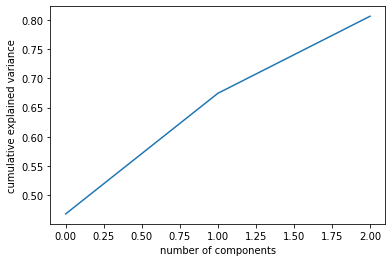

In [4]:
n = 3

pipe = Pipeline([
        ('scale', StandardScaler()),
        ('reduce_dims', PCA(n_components=n))]
        )

df_model[[f'pca_{i}' for i in range(n)]] = pipe.fit_transform(df_model[reduced_terms_list])

pipe = Pipeline([
        ('scale', StandardScaler()),
        ('reduce_dims', PCA(n_components=n))]
        )
pipe.fit(df_model[reduced_terms_list])

plt.plot(np.cumsum(pipe['reduce_dims'].explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance')

## Anderson Hsiao / Arellano bond estimates
Suspecting there is reverse causality, we introduce the endogenouos variable as a regressor to reduce it:
$$\log GDP_t = \beta PCA_t + \log GDP_{t-1} + \Delta\epsilon$$

We estimate the model in differences
$$\Delta\log GDP_t = \beta\Delta PCA + \Delta\epsilon$$

As instruments we use lagged values of  $\log GDP$, which are:
- Exogenous: not related to future values of $\log GDP$
- Relevant: related to lagged PCA

Depending on the number of lags used: 
- Anderson-Hsiao: 1 lag
- Arellano-Bond: all available

In [5]:
df_index = df_model.set_index(['country', 'year'])
model = PanelLaggedDep(endog = df_index['log_gdp'],
                       exogs = df_index[reduced_terms_list], 
                       systemGMM = False,
                       iv_max_lags=1)

results = model.fit()

print(results.summary)

                          IV-GMM Estimation Summary                           
Dep. Variable:               Dlog_gdp   R-squared:                      0.0037
Estimator:                     IV-GMM   Adj. R-squared:                 0.0013
No. Observations:                3348   F-statistic:                    638.57
Date:                Mon, Dec 20 2021   P-value (F-stat)                0.0000
Time:                        18:06:08   Distribution:                  chi2(8)
Cov. Estimator:                robust                                         
                                                                              
                                   Parameter Estimates                                    
                        Parameter  Std. Err.     T-stat    P-value    Lower CI    Upper CI
------------------------------------------------------------------------------------------
Dfinancial_hubs           -0.1240     0.0886    -1.3993     0.1617     -0.2977      0.0497
Dfin

/repos/social_capital_in_trade_networks/notebooks/arellano_bond.py:107: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dropped['CLUSTER_VAR'] = dropped.index.get_level_values(0)


In [6]:
df_index = df_model.set_index(['country', 'year'])
model = PanelLaggedDep(endog = df_index['log_gdp'],
                       exogs = df_index[[f'pca_{i}' for i in range(n)]], 
                       systemGMM = False,
                       iv_max_lags=1,
                       lags=1)

results = model.fit()

print(results.summary)

                          IV-GMM Estimation Summary                           
Dep. Variable:               Dlog_gdp   R-squared:                      0.0009
Estimator:                     IV-GMM   Adj. R-squared:                -0.0003
No. Observations:                3348   F-statistic:                    356.10
Date:                Mon, Dec 20 2021   P-value (F-stat)                0.0000
Time:                        18:06:08   Distribution:                  chi2(4)
Cov. Estimator:                robust                                         
                                                                              
                             Parameter Estimates                              
            Parameter  Std. Err.     T-stat    P-value    Lower CI    Upper CI
------------------------------------------------------------------------------
Dpca_0        -0.0244     0.0133    -1.8248     0.0680     -0.0505      0.0018
Dpca_1        -0.0191     0.1081    -0.1764     0.86

/repos/social_capital_in_trade_networks/notebooks/arellano_bond.py:107: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dropped['CLUSTER_VAR'] = dropped.index.get_level_values(0)


In [7]:
df_index = df_model.set_index(['country', 'year'])
model = PanelLaggedDep(endog = df_index['pca_0'],
                       exogs = df_index[['log_gdp']], 
                       systemGMM = False,
                       iv_max_lags=1,
                       lags=1)

results = model.fit()

print(results.summary)

                          IV-GMM Estimation Summary                           
Dep. Variable:                 Dpca_0   R-squared:                      0.2528
Estimator:                     IV-GMM   Adj. R-squared:                 0.2523
No. Observations:                3348   F-statistic:                    122.46
Date:                Mon, Dec 20 2021   P-value (F-stat)                0.0000
Time:                        18:06:08   Distribution:                  chi2(2)
Cov. Estimator:                robust                                         
                                                                              
                             Parameter Estimates                              
            Parameter  Std. Err.     T-stat    P-value    Lower CI    Upper CI
------------------------------------------------------------------------------
Dlog_gdp      -0.1198     0.1074    -1.1155     0.2646     -0.3304      0.0907
L1Dpca_0      -0.2416     0.0261    -9.2645     0.00

/repos/social_capital_in_trade_networks/notebooks/arellano_bond.py:107: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dropped['CLUSTER_VAR'] = dropped.index.get_level_values(0)
